In [1]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

## Initial exploratory data analysis before building models.


In [2]:
with open('./data/cleaned_dataframe.pickle','rb') as read_file:
    df = pickle.load(read_file)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1935 entries, 0 to 2292
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1935 non-null   float64
 1   Pos          1935 non-null   object 
 2   G            1935 non-null   float64
 3   GS           1935 non-null   float64
 4   Wt           1935 non-null   float64
 5   Ht           1935 non-null   float64
 6   College      1935 non-null   object 
 7   Yrs          1935 non-null   float64
 8   AV           1935 non-null   float64
 9   Salary       1935 non-null   float64
 10  Team         1935 non-null   object 
 11  Record       1935 non-null   float64
 12  general_pos  1935 non-null   object 
 13  pos_group    1935 non-null   object 
 14  starter      1935 non-null   object 
 15  BMI          1935 non-null   float64
 16  ht_pos       1935 non-null   object 
 17  wt_pos       1935 non-null   object 
dtypes: float64(10), object(8)
memory usage: 287.2+ K

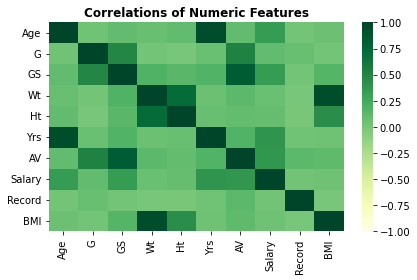

In [4]:
# Figure of numeric correlations (in this case, mostly for the presentation).

sns.heatmap(df.corr(), cmap="YlGn", annot=False, vmin=-1, vmax=1)
plt.title("Correlations of Numeric Features", weight="bold")

plt.tight_layout()
plt.savefig("./Figures/corr_dist.jpg");

<Figure size 504x504 with 0 Axes>

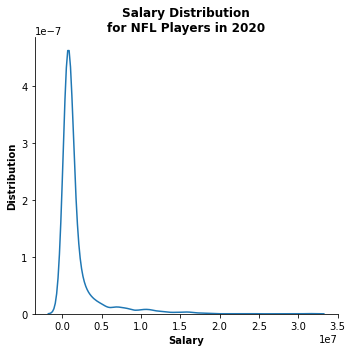

In [5]:
# Plot the distribution of Salary (the target).

plt.figure(figsize=(7,7))

sns.displot(data=df, x="Salary", kind="kde")
plt.title("Salary Distribution\nfor NFL Players in 2020", weight="bold")
plt.xlabel("Salary", weight="bold")
plt.ylabel("Distribution", weight="bold")

plt.tight_layout() 
plt.savefig("./Figures/salary_dist.jpg");

In [6]:
# From above it seems a good idea to try log transforming the target.

df["log_salary"] = np.log(df["Salary"])

<Figure size 504x504 with 0 Axes>

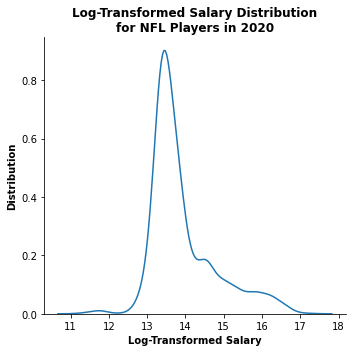

In [7]:
# Plot the distribution of the log-transformed salary (the "new" target).

plt.figure(figsize=(7,7))

sns.displot(data=df, x="log_salary", kind="kde")
plt.title("Log-Transformed Salary Distribution\nfor NFL Players in 2020", weight="bold")
plt.xlabel("Log-Transformed Salary", weight="bold")
plt.ylabel("Distribution", weight="bold")

plt.tight_layout() 
plt.savefig("./Figures/salary_log_dist.jpg");

In [8]:
df.corr()

,Age,G,GS,Wt,Ht,Yrs,AV,Salary,Record,BMI,log_salary
Age,1.000000,0.035746,0.098750,0.076869,0.099248,0.941107,0.097228,0.346066,0.021569,0.052443,0.480633
G,0.035746,1.000000,0.490054,0.018417,0.002894,0.065533,0.516179,0.095243,0.075617,0.022667,0.197331
GS,0.098750,0.490054,1.000000,0.179701,0.135035,0.177068,0.828337,0.344664,0.022210,0.163581,0.440352
Wt,0.076869,0.018417,0.179701,1.000000,0.715383,0.058069,0.125169,0.066066,0.003212,0.942822,0.091803
Ht,0.099248,0.002894,0.135035,0.715383,1.000000,0.071568,0.087631,0.080002,-0.002908,0.445228,0.092524
Yrs,0.941107,0.065533,0.177068,0.058069,0.071568,1.000000,0.174835,0.395212,0.032647,0.041370,0.547587
AV,0.097228,0.516179,0.828337,0.125169,0.087631,0.174835,1.000000,0.375910,0.131081,0.116552,0.431937
Salary,0.346066,0.095243,0.344664,0.066066,0.080002,0.395212,0.375910,1.000000,0.030955,0.043864,0.870488
Record,0.021569,0.075617,0.022210,0.003212,-0.002908,0.032647,0.131081,0.030955,1.000000,0.004507,0.038382
BMI,0.052443,0.022667,0.163581,0.942822,0.445228,0.041370,0.116552,0.043864,0.004507,1.000000,0.070925


In [9]:
# sns.pairplot(df, height=1.2, aspect=1.5);

## Modeling

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [11]:
# Create a function that I can use repeatedly to try out different features.

def train_models(X, y, cat=False):
    """
    For a set of features (X) and target (y), perform a train/val split, 
    fit and validate different regression models, and report results. 
    
    Models tested are: OLS, polynomial, Ridge, and Lasso.
    (Ridge and Lasso regressions undergo training to find best alpha).
    
    If there's a categorical column included, then convert for modeling.
    (But don't include in the polynomial model).
    
    Prints R^2 results, mean abs error, and root mean sqr error.
    """
    
    scaler = StandardScaler()
    poly = PolynomialFeatures(degree=2)
    
    # Add dummies for categorical data (after scaling for Ridge/Lasso). 
    if cat:
        X_cat = X[cat]
        X_no_cat = X.drop(columns=cat)
        
        # Create polynomial features (dropping categorical features).
        X_train_poly = poly.fit_transform(X_no_cat)

        # Create dummies for OLS too.
        X_cat = pd.get_dummies(X_cat, drop_first=True).to_numpy()
        X = pd.get_dummies(X, drop_first=True)

        # Scale the numerical features.
        X_train_scaled = scaler.fit_transform(X_no_cat.values)
        
        # Combine dummies with scaled features.
        X_train_scaled = np.concatenate((X_train_scaled, X_cat), axis=1)
    
    else:
        # Create polynomial features.
        X_train_poly = poly.fit_transform(X)

        # Scale the features.
        X_train_scaled = scaler.fit_transform(X.values)
        
    
    
    # Run cross validation on Ridge regression to find the best alpha, 
    # Then will refit the model with that alpha
    alphavec = 10**np.linspace(-4,4,1000)
    ridge_model = RidgeCV(alphas = alphavec, cv=5)
    ridge_model.fit(X_train_scaled, y)
    # This is the best alpha value it found:
    ridge_alpha_to_use = ridge_model.alpha_
    
    
    # Run cross validation on Lasso regression to find the best alpha. 
    # Then will refit the model with that alpha
    alphavec = 10**np.linspace(-4,4,1000)
    lasso_model = LassoCV(alphas = alphavec, cv=5)
    lasso_model.fit(X_train_scaled, y)
    # This is the best alpha value it found:
    lasso_alpha_to_use = lasso_model.alpha_
    
    
    # Cross validation of the simple linear model and lasso and ridge models.
    kf = KFold(n_splits=5, shuffle=True, random_state = 13)

    # Regression models (using alphas determined above).
    lm_OLS = LinearRegression()
    lm_poly = LinearRegression()
    lm_ridge = Ridge(alpha=ridge_alpha_to_use)
    lm_lasso = Lasso(alpha=lasso_alpha_to_use)

    # Print the R^2 values for each model.
    print("R^2 (on training dataset):")
    print(f"OLS: {np.mean(cross_val_score(lm_OLS, X, y, cv=kf, scoring='r2')):.4f}")
    print(f"Polynomial: {np.mean(cross_val_score(lm_poly, X_train_poly, y, cv=kf, scoring='r2')):.4f}")
    print(f"Ridge: {np.mean(cross_val_score(lm_ridge, X_train_scaled, y, cv=kf, scoring='r2')):.4f}")
    print(f"Lasso: {np.mean(cross_val_score(lm_lasso, X_train_scaled, y, cv=kf, scoring='r2')):.4f}")

    # Train the model using the training dataset.
    lm_OLS.fit(X, y)
    lm_poly.fit(X_train_poly, y)
    lm_ridge.fit(X_train_scaled, y)
    lm_lasso.fit(X_train_scaled, y)

    # Determine the predicted values.
    y_train_not_log = np.exp(y)
    X_train_pred_lm = np.exp(lm_OLS.predict(X))
    X_train_pred_lr_poly = np.exp(lm_poly.predict(X_train_poly))
    X_train_pred_lm_ridge = np.exp(lm_ridge.predict(X_train_scaled))
    X_train_pred_lm_lasso = np.exp(lm_lasso.predict(X_train_scaled))

    # Print the MAE values for each model (have converted them from log for dollars).
    # MAE not impacted by outliers as much.
    print("\n")
    print("MAE (on training dataset):")
    print(f"OLS: {round(mean_absolute_error(y_train_not_log, X_train_pred_lm)):,}")
    print(f"Polynomial: {round(mean_absolute_error(y_train_not_log, X_train_pred_lr_poly)):,}")
    print(f"Ridge: {round(mean_absolute_error(y_train_not_log, X_train_pred_lm_ridge)):,}")
    print(f"Lasso: {round(mean_absolute_error(y_train_not_log, X_train_pred_lm_lasso)):,}")

    # Print the RMSE values for each model (have converted them from log for dollars).
    # RMSE impacted by outliers more (maybe not ideal for this dataset then).
    print("\n")
    print("RMSE (on training dataset):")
    print(f"OLS: {round(mean_squared_error(y_train_not_log, X_train_pred_lm, squared=False)):,}")
    print(f"Polynomial: {round(mean_squared_error(y_train_not_log, X_train_pred_lr_poly, squared=False)):,}")
    print(f"Ridge: {round(mean_squared_error(y_train_not_log, X_train_pred_lm_ridge, squared=False)):,}")
    print(f"Lasso: {round(mean_squared_error(y_train_not_log, X_train_pred_lm_lasso, squared=False)):,}")
    
    if cat:
        print("\n", "**Polynomial regression does not include categorical variables**")

## Test different models

#### (keeping the random state the same for each so it's always using the same data for training)

In [12]:
# 1) Start with those with correlation ≥0.10 (and aren't strongly correlated to each other (≥0.50?))

X = df[["Yrs", "G", "AV"]]
y = df["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

train_models(X_train, y_train)

R^2 (on training dataset):
Simple: 0.4140
Polynomial: 0.4905
Ridge: 0.4141
Lasso: 0.4144


MAE (on training dataset):
Simple: 1,062,736
Polynomial: 1,005,190
Ridge: 1,061,867
Lasso: 1,061,374


RMSE (on training dataset):
Simple: 2,478,454
Polynomial: 2,350,511
Ridge: 2,477,417
Lasso: 2,478,405


In [13]:
# 2) GS and AV are highly correlated.

X = df[["Yrs", 'GS', "G"]]
y = df["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

train_models(X_train, y_train)

R^2 (on training dataset):
Simple: 0.4236
Polynomial: 0.4916
Ridge: 0.4237
Lasso: 0.4239


MAE (on training dataset):
Simple: 1,057,021
Polynomial: 1,011,841
Ridge: 1,056,388
Lasso: 1,055,320


RMSE (on training dataset):
Simple: 2,481,842
Polynomial: 2,388,160
Ridge: 2,482,898
Lasso: 2,485,668


In [14]:
# 3) Trying height and weight (Ht not as good).

X = df[["Yrs", 'GS', "G", "Wt"]]
y = df["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

train_models(X_train, y_train)

R^2 (on training dataset):
Simple: 0.4220
Polynomial: 0.4882
Ridge: 0.4221
Lasso: 0.4236


MAE (on training dataset):
Simple: 1,056,955
Polynomial: 1,007,117
Ridge: 1,056,222
Lasso: 1,054,887


RMSE (on training dataset):
Simple: 2,481,755
Polynomial: 2,376,505
Ridge: 2,483,018
Lasso: 2,486,748


In [15]:
# 4) Trying BMI.

X = df[["Yrs", 'GS', "G", "BMI"]]
y = df["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

train_models(X_train, y_train)

R^2 (on training dataset):
Simple: 0.4219
Polynomial: 0.4883
Ridge: 0.4220
Lasso: 0.4233


MAE (on training dataset):
Simple: 1,056,868
Polynomial: 1,004,126
Ridge: 1,056,175
Lasso: 1,054,613


RMSE (on training dataset):
Simple: 2,481,334
Polynomial: 2,370,045
Ridge: 2,482,544
Lasso: 2,487,468


In [16]:
# 4.5) Start with those with correlation ≥0.10 (and aren't strongly correlated to each other (≥0.50?))

X = df[["Yrs", "G", "AV", "Wt"]]
y = df["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

train_models(X_train, y_train)

R^2 (on training dataset):
Simple: 0.4126
Polynomial: 0.4831
Ridge: 0.4128
Lasso: 0.4134


MAE (on training dataset):
Simple: 1,061,998
Polynomial: 1,000,821
Ridge: 1,061,104
Lasso: 1,061,097


RMSE (on training dataset):
Simple: 2,477,029
Polynomial: 2,343,456
Ridge: 2,476,097
Lasso: 2,478,002


In [17]:
# 5) Trying weight categories.

X = df[["Yrs", 'GS', "G", "wt_pos"]]
y = df["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

train_models(X_train, y_train, "wt_pos")

R^2 (on training dataset):
Simple: 0.4232
Polynomial: 0.4916
Ridge: 0.4233
Lasso: 0.4239


MAE (on training dataset):
Simple: 1,057,035
Polynomial: 1,011,841
Ridge: 1,056,314
Lasso: 1,055,320


RMSE (on training dataset):
Simple: 2,481,793
Polynomial: 2,388,160
Ridge: 2,483,013
Lasso: 2,485,668

 **Polynomial regression does not include categorical variables**


### Best of the numeric-only features:

In [18]:
# This seems to be best of numeric data.

# 6) Trying record added in.

X = df[["Yrs", 'GS', "G", "BMI", "Record"]]
y = df["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

train_models(X_train, y_train)

R^2 (on training dataset):
Simple: 0.4221
Polynomial: 0.4869
Ridge: 0.4222
Lasso: 0.4234


MAE (on training dataset):
Simple: 1,056,530
Polynomial: 1,003,139
Ridge: 1,055,778
Lasso: 1,054,340


RMSE (on training dataset):
Simple: 2,481,244
Polynomial: 2,366,100
Ridge: 2,482,505
Lasso: 2,487,636


In [19]:
# 7) Using best of the numeric and adding in categories.

X = df[["Yrs", 'GS', "G", "BMI", "Record", "pos_group"]]
y = df["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

train_models(X_train, y_train, "pos_group")

R^2 (on training dataset):
Simple: 0.4235
Polynomial: 0.4869
Ridge: 0.4239
Lasso: 0.4244


MAE (on training dataset):
Simple: 1,053,497
Polynomial: 1,003,139
Ridge: 1,052,633
Lasso: 1,054,031


RMSE (on training dataset):
Simple: 2,467,623
Polynomial: 2,366,100
Ridge: 2,475,392
Lasso: 2,475,478

 **Polynomial regression does not include categorical variables**


In [20]:
# Not as good as more specific position group.
# 8) Using best of the numeric and adding in categories.

X = df[["Yrs", 'GS', "G", "BMI", "Record", "general_pos"]]
y = df["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

train_models(X_train, y_train, "general_pos")

R^2 (on training dataset):
Simple: 0.4202
Polynomial: 0.4869
Ridge: 0.4208
Lasso: 0.4234


MAE (on training dataset):
Simple: 1,056,392
Polynomial: 1,003,139
Ridge: 1,054,615
Lasso: 1,054,340


RMSE (on training dataset):
Simple: 2,481,460
Polynomial: 2,366,100
Ridge: 2,484,876
Lasso: 2,487,636

 **Polynomial regression does not include categorical variables**


### Best of the numeric + categorical features.

In [21]:
# Best of the position categories.
# 9) Using best of the numeric and adding in categories.

X = df[["Yrs", 'GS', "G", "BMI", "Record", "Pos"]]
y = df["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

train_models(X_train, y_train, "Pos")

R^2 (on training dataset):
Simple: 0.4178
Polynomial: 0.4869
Ridge: 0.4277
Lasso: 0.4262


MAE (on training dataset):
Simple: 1,037,113
Polynomial: 1,003,139
Ridge: 1,044,309
Lasso: 1,046,444


RMSE (on training dataset):
Simple: 2,446,758
Polynomial: 2,366,100
Ridge: 2,462,570
Lasso: 2,462,050

 **Polynomial regression does not include categorical variables**


In [22]:
# 10) Using best of the numeric and adding in categories.

X = df[["Yrs", 'GS', "G", "BMI", "Record", "starter"]]
y = df["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

train_models(X_train, y_train, "starter")

R^2 (on training dataset):
Simple: 0.4230
Polynomial: 0.4869
Ridge: 0.4231
Lasso: 0.4231


MAE (on training dataset):
Simple: 1,059,023
Polynomial: 1,003,139
Ridge: 1,058,789
Lasso: 1,058,798


RMSE (on training dataset):
Simple: 2,478,131
Polynomial: 2,366,100
Ridge: 2,478,951
Lasso: 2,478,844

 **Polynomial regression does not include categorical variables**


In [23]:
# 11) Using best of the numeric and adding in categories.

X = df[["Yrs", 'GS', "G", "BMI", "Record", "starter", "pos_group"]]
y = df["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

train_models(X_train, y_train, ["starter", "pos_group"])

R^2 (on training dataset):
Simple: 0.4246
Polynomial: 0.4869
Ridge: 0.4252
Lasso: 0.4254


MAE (on training dataset):
Simple: 1,055,207
Polynomial: 1,003,139
Ridge: 1,055,604
Lasso: 1,055,866


RMSE (on training dataset):
Simple: 2,464,601
Polynomial: 2,366,100
Ridge: 2,470,973
Lasso: 2,475,685

 **Polynomial regression does not include categorical variables**


In [24]:
# 12) Using best of the numeric and adding in categories.

X = df[["Yrs", 'GS', "G", "BMI", "Record", "starter", "Pos"]]
y = df["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

train_models(X_train, y_train, ["starter", "Pos"])

R^2 (on training dataset):
Simple: 0.4184
Polynomial: 0.4869
Ridge: 0.4283
Lasso: 0.4270


MAE (on training dataset):
Simple: 1,038,258
Polynomial: 1,003,139
Ridge: 1,045,884
Lasso: 1,048,130


RMSE (on training dataset):
Simple: 2,444,233
Polynomial: 2,366,100
Ridge: 2,460,210
Lasso: 2,461,616

 **Polynomial regression does not include categorical variables**


In [25]:
# 13) Using best of the numeric and adding in categories.

X = df[["Yrs", 'GS', "G", "BMI", "Record", "Team"]]
y = df["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

train_models(X_train, y_train, "Team")

R^2 (on training dataset):
Simple: 0.4140
Polynomial: 0.4869
Ridge: 0.4233
Lasso: 0.4234


MAE (on training dataset):
Simple: 1,042,799
Polynomial: 1,003,139
Ridge: 1,045,131
Lasso: 1,054,340


RMSE (on training dataset):
Simple: 2,447,385
Polynomial: 2,366,100
Ridge: 2,472,411
Lasso: 2,487,636

 **Polynomial regression does not include categorical variables**


## Try the best of the above models on the test dataset.
### (Numeric features only)

In [26]:
X = df[["Yrs", 'GS', "G", "BMI", "Record"]]
y = df["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

# Run cross validation on Ridge regression to find the best alpha, 
# Then will refit the model with that alpha
alphavec = 10**np.linspace(-4,4,1000)
ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_train_scaled, y_train)
# This is the best alpha value it found:
ridge_alpha_to_use = ridge_model.alpha_
print(ridge_alpha_to_use)

# Run cross validation on Lasso regression to find the best alpha. 
# Then will refit the model with that alpha
alphavec = 10**np.linspace(-4,4,1000)
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train_scaled, y_train)
# This is the best alpha value it found:
lasso_alpha_to_use = lasso_model.alpha_
print(lasso_alpha_to_use)

14.360089846512606
0.012767507043192657


In [27]:
from scipy.stats import pearsonr

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

# Regression models (using alphas determined above).
lm_OLS = LinearRegression()
lm_poly = LinearRegression()
lm_ridge = Ridge(alpha=ridge_alpha_to_use)
lm_lasso = Lasso(alpha=lasso_alpha_to_use)

# Train the model using the training dataset.
lm_OLS.fit(X_train, y_train)
lm_poly.fit(X_train_poly, y_train)
lm_ridge.fit(X_train_scaled, y_train)
lm_lasso.fit(X_train_scaled, y_train)

# Determine the predicted values.
y_test_not_log = np.exp(y_test)
X_test_pred_lm = np.exp(lm_OLS.predict(X_test))
X_test_pred_lr_poly = np.exp(lm_poly.predict(X_test_poly))
X_test_pred_lm_ridge = np.exp(lm_ridge.predict(X_test_scaled))
X_test_pred_lm_lasso = np.exp(lm_lasso.predict(X_test_scaled))


# Print the R^2 values for each model.
print("R^2 (on TEST dataset):")
print(f"OLS: {pearsonr(y_test_not_log, X_test_pred_lm)[0]:.4f}")
print(f"Polynomial: {pearsonr(y_test_not_log, X_test_pred_lr_poly)[0]:.4f}")
print(f"Ridge: {pearsonr(y_test_not_log, X_test_pred_lm_ridge)[0]:.4f}")
print(f"Lasso: {pearsonr(y_test_not_log, X_test_pred_lm_lasso)[0]:.4f}")


# Print the MAE values for each model (have converted them from log for dollars).
# MAE not impacted by outliers as much.
print("\n")
print("MAE (on TEST dataset):")
print(f"OLS: {round(mean_absolute_error(y_test_not_log, X_test_pred_lm)):,}")
print(f"Polynomial: {round(mean_absolute_error(y_test_not_log, X_test_pred_lr_poly)):,}")
print(f"Ridge: {round(mean_absolute_error(y_test_not_log, X_test_pred_lm_ridge)):,}")
print(f"Lasso: {round(mean_absolute_error(y_test_not_log, X_test_pred_lm_lasso)):,}")
    
    
# Print the RMSE values for each model (have converted them from log for dollars).
# RMSE impacted by outliers more (maybe not ideal for this dataset then).
print("\n")
print("RMSE (on TEST dataset):")
print(f"OLS: {round(mean_squared_error(y_test_not_log, X_test_pred_lm, squared=False)):,}")
print(f"Polynomial: {round(mean_squared_error(y_test_not_log, X_test_pred_lr_poly, squared=False)):,}")
print(f"Ridge: {round(mean_squared_error(y_test_not_log, X_test_pred_lm_ridge, squared=False)):,}")
print(f"Lasso: {round(mean_squared_error(y_test_not_log, X_test_pred_lm_lasso, squared=False)):,}")

R^2 (on TEST dataset):
Simple: 0.3789
Polynomial: 0.5008
Ridge: 0.3798
Lasso: 0.3828


MAE (on TEST dataset):
Simple: 1,145,257
Polynomial: 1,068,752
Ridge: 1,144,560
Lasso: 1,144,151


RMSE (on TEST dataset):
Simple: 2,878,780
Polynomial: 2,765,948
Ridge: 2,879,772
Lasso: 2,882,219


## Try the best of the above models on the test dataset.
### (Numeric + Categorical features)

In [28]:
X = df[["Yrs", 'GS', "G", "BMI", "Record", "Pos"]]
y = df["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

# Two datasets - 1 with categorical, the other without (that then gets scaled).
X_train_cat = X_train["Pos"]
X_train_no_cat = X_train.drop(columns="Pos")
X_test_cat = X_test["Pos"]
X_test_no_cat = X_test.drop(columns="Pos")


# Create polynomial features (without categorical features).
X_train_poly = poly.fit_transform(X_train_no_cat)
X_test_poly = poly.fit_transform(X_test_no_cat)

# Create dummies for OLS too.
X_train_cat = pd.get_dummies(X_train_cat, drop_first=True)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

########################################
"""
The train and test datasets end up with different columns
because of low numbers in some of the player positions. 
This below makes the columns equal so you can get predictions.
"""

# For OLS: Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( X_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X_train.columns]

# For Ridge/Lasso: Get missing columns in the training test
missing_cols = set( X_train_cat.columns ) - set( X_test_cat.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test_cat[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X_test_cat = X_test_cat[X_train_cat.columns]
########################################

X_train_cat = X_train_cat.to_numpy()
X_test_cat = X_test_cat.to_numpy()


# Scale the numerical features.
X_train_scaled = scaler.fit_transform(X_train_no_cat.values)
X_test_scaled = scaler.fit_transform(X_test_no_cat.values)

# Combine dummies with scaled features.
X_train_scaled = np.concatenate((X_train_scaled, X_train_cat), axis=1)
X_test_scaled = np.concatenate((X_test_scaled, X_test_cat), axis=1)

# Run cross validation on Ridge regression to find the best alpha, 
# Then will refit the model with that alpha
alphavec = 10**np.linspace(-4,4,1000)
ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_train_scaled, y_train)
# This is the best alpha value it found:
ridge_alpha_to_use = ridge_model.alpha_
print(ridge_alpha_to_use)

# Run cross validation on Lasso regression to find the best alpha. 
# Then will refit the model with that alpha
alphavec = 10**np.linspace(-4,4,1000)
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train_scaled, y_train)
# This is the best alpha value it found:
lasso_alpha_to_use = lasso_model.alpha_
print(lasso_alpha_to_use)

27.889802923804396
0.0023408272761782944


In [29]:
# Have to make sure the train and test datasets have the same number of columns (same number of dummies).


# Regression models (using alphas determined above).
lm_OLS = LinearRegression()
lm_poly = LinearRegression()
lm_ridge = Ridge(alpha=ridge_alpha_to_use)
lm_lasso = Lasso(alpha=lasso_alpha_to_use)

# Train the model using the training dataset.
lm_OLS.fit(X_train, y_train)
lm_poly.fit(X_train_poly, y_train)
lm_ridge.fit(X_train_scaled, y_train)
lm_lasso.fit(X_train_scaled, y_train)

# Determine the predicted values.
y_test_not_log = np.exp(y_test)
X_test_pred_lm = np.exp(lm_OLS.predict(X_test))
X_test_pred_lr_poly = np.exp(lm_poly.predict(X_test_poly))
X_test_pred_lm_ridge = np.exp(lm_ridge.predict(X_test_scaled))
X_test_pred_lm_lasso = np.exp(lm_lasso.predict(X_test_scaled))


# Print the R^2 values for each model.
print("R^2 (on TEST dataset):")
print(f"OLS: {pearsonr(y_test_not_log, X_test_pred_lm)[0]:.4f}")
print(f"Polynomial: {pearsonr(y_test_not_log, X_test_pred_lr_poly)[0]:.4f}")
print(f"Ridge: {pearsonr(y_test_not_log, X_test_pred_lm_ridge)[0]:.4f}")
print(f"Lasso: {pearsonr(y_test_not_log, X_test_pred_lm_lasso)[0]:.4f}")


# Print the MAE values for each model (have converted them from log for dollars).
# MAE not impacted by outliers as much.
print("\n")
print("MAE (on TEST dataset):")
print(f"OLS: {round(mean_absolute_error(y_test_not_log, X_test_pred_lm)):,}")
print(f"Polynomial: {round(mean_absolute_error(y_test_not_log, X_test_pred_lr_poly)):,}")
print(f"Ridge: {round(mean_absolute_error(y_test_not_log, X_test_pred_lm_ridge)):,}")
print(f"Lasso: {round(mean_absolute_error(y_test_not_log, X_test_pred_lm_lasso)):,}")
    
    
# Print the RMSE values for each model (have converted them from log for dollars).
# RMSE impacted by outliers more (maybe not ideal for this dataset then).
print("\n")
print("RMSE (on TEST dataset):")
print(f"OLS: {round(mean_squared_error(y_test_not_log, X_test_pred_lm, squared=False)):,}")
print(f"Polynomial: {round(mean_squared_error(y_test_not_log, X_test_pred_lr_poly, squared=False)):,}")
print(f"Ridge: {round(mean_squared_error(y_test_not_log, X_test_pred_lm_ridge, squared=False)):,}")
print(f"Lasso: {round(mean_squared_error(y_test_not_log, X_test_pred_lm_lasso, squared=False)):,}")

R^2 (on TEST dataset):
Simple: 0.4203
Polynomial: 0.5008
Ridge: 0.3973
Lasso: 0.3941


MAE (on TEST dataset):
Simple: 1,136,849
Polynomial: 1,068,752
Ridge: 1,144,786
Lasso: 1,144,419


RMSE (on TEST dataset):
Simple: 2,839,722
Polynomial: 2,765,948
Ridge: 2,855,567
Lasso: 2,855,079


## Graphing

In [30]:
# ALL DATA
X = df[["Yrs", 'GS', "G", "BMI", "Record"]]
y = df["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_poly = poly.fit_transform(X)

# Regression models (using alphas determined above).
lm_poly = LinearRegression()
# Train the model.
lm_poly.fit(X_train_poly, y_train)

df['predict'] = lm_poly.predict(X_poly)
df['resid'] = df["log_salary"] - df["predict"]
df['resid'] = df["log_salary"] - df["predict"]

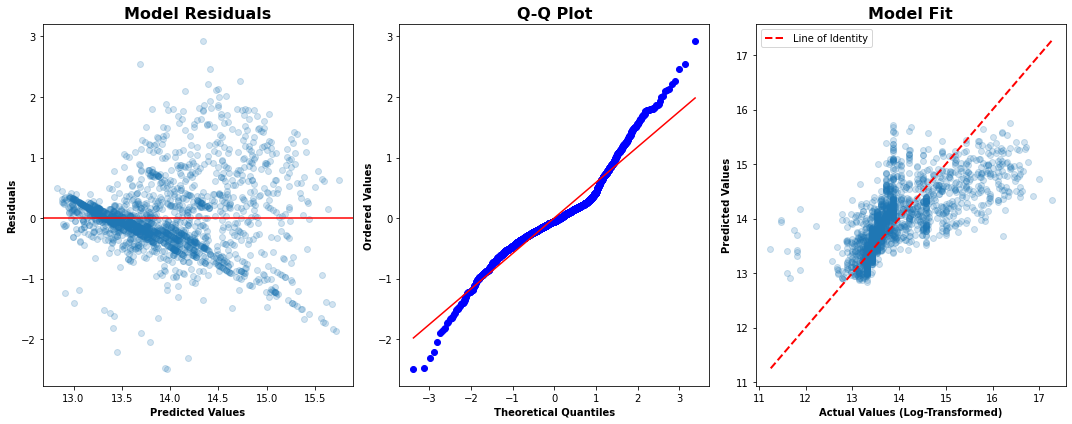

In [31]:
# Plots of model fit.

fig, axs = plt.subplots(1,3, figsize=(15,6))

axs[0].scatter(data=df, x='predict',y='resid', alpha=0.2)
axs[0].axhline(y=0.0, color="r")
axs[0].set_title("Model Residuals", fontweight="bold", fontsize=16)
axs[0].set_xlabel("Predicted Values", weight="bold")
axs[0].set_ylabel("Residuals", weight="bold")


# sm.qqplot(df['resid'], fit=True, line="q",ax = axs[1])
stats.probplot(df['resid'], dist="norm", plot=axs[1])
axs[1].set_title("Q-Q Plot", fontweight="bold", fontsize=16)
axs[1].set_xlabel("Theoretical Quantiles", weight="bold")
axs[1].set_ylabel("Ordered Values", weight="bold");
# axs[1].yaxis.set_label_position("right")
# axs[1].yaxis.tick_right()

axs[2].scatter(data=df, x='log_salary',y='predict', alpha=0.2)
# To add line of best fit.
# line_fit = np.polyfit(df["log_salary"],df["predict"], 1)
# axs[2].plot(df["log_salary"], line_fit[0]*df["log_salary"]+line_fit[1], color="k")
p1 = max(max(df["log_salary"]), max(df["predict"]))
p2 = min(min(df["log_salary"]), min(df["predict"]))
axs[2].plot([p1, p2], [p1, p2], 'r--', linewidth=2.0)
axs[2].legend(["Line of Identity"])
axs[2].set_title("Model Fit", fontweight="bold", fontsize=16)
axs[2].set_xlabel("Actual Values (Log-Transformed)", weight="bold")
axs[2].set_ylabel("Predicted Values", weight="bold")

plt.tight_layout()
plt.savefig("./Figures/fit_3_figure.jpg");

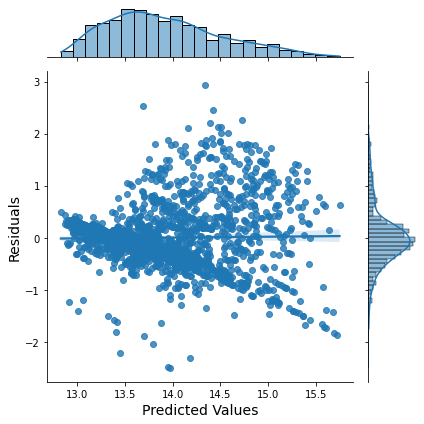

In [32]:
h = sns.jointplot(x='predict',y='resid', kind = "reg", data = df)
h.set_axis_labels('Predicted Values', 'Residuals', fontsize=14)

plt.tight_layout()
plt.savefig("./Figures/resid_joint_figure.jpg");

## Training models without outliers (then testing with the outliers)

In [33]:
# Drop salary outliers (in this case z-score > 4).

df_no_outliers = df.copy()
df_no_outliers["salary_z"] = stats.zscore(df_no_outliers["Salary"], ddof=1)

df_no_outliers = df_no_outliers.query("salary_z < 4")
# df_no_outliers.sort_values("salary_z", ascending=True).head(30)
# df_no_outliers.info()

In [38]:
# Best of the position categories.
# 9) Using best of the numeric categories.

X = df_no_outliers[["Yrs", 'GS', "G", "BMI", "Record"]]
y = df_no_outliers["log_salary"]

# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

print("Models based on NO outliers")
print("\n")
train_models(X_train, y_train)

Models based on NO outliers


R^2 (on training dataset):
Simple: 0.4014
Polynomial: 0.4587
Ridge: 0.4015
Lasso: 0.4032


MAE (on training dataset):
Simple: 862,850
Polynomial: 816,313
Ridge: 862,327
Lasso: 862,244


RMSE (on training dataset):
Simple: 1,868,327
Polynomial: 1,772,114
Ridge: 1,869,574
Lasso: 1,871,916


In [39]:
# Try the POLYNOMIAL model (on the best of the numeric-only data)

X_no_outliers = df_no_outliers[["Yrs", 'GS', "G", "BMI", "Record"]]
y_no_outliers = df_no_outliers["log_salary"]
# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2,random_state=13)

# ALL DATA
X = df[["Yrs", 'GS', "G", "BMI", "Record"]]
y = df["log_salary"]
# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_no_outliers)
# Keep the original X.
X_test_poly = poly.fit_transform(X_test)


# Regression models (using alphas determined above).
lm_poly = LinearRegression()

# Train the model using the NO OUTLIER training dataset.
lm_poly.fit(X_train_poly, y_train_no_outliers)


# Print the R^2 values for each model.
print("R^2 (on TEST dataset):")
print(f"Polynomial: {lm_poly.score(X_test_poly, y_test):.4f}")


# Determine the predicted values.
y_test_not_log = np.exp(y_test)
X_test_pred_lr_poly = np.exp(lm_poly.predict(X_test_poly))

# Print the MAE values for each model (have converted them from log for dollars).
# MAE not impacted by outliers as much.
print("\n")
print("MAE (on TEST dataset):")
print(f"Polynomial: {round(mean_absolute_error(y_test_not_log, X_test_pred_lr_poly)):,}")

# Print the RMSE values for each model (have converted them from log for dollars).
# RMSE impacted by outliers more (maybe not ideal for this dataset then).
print("\n")
print("RMSE (on TEST dataset):")
print(f"Polynomial: {round(mean_squared_error(y_test_not_log, X_test_pred_lr_poly, squared=False)):,}")


R^2 (on TEST dataset):
Polynomial: 0.4857


MAE (on TEST dataset):
Polynomial: 1,071,644


RMSE (on TEST dataset):
Polynomial: 2,792,746


In [40]:
# Try the OLS model (on the best of the numeric-only data)

X_no_outliers = df_no_outliers[["Yrs", 'GS', "G", "BMI", "Record"]]
y_no_outliers = df_no_outliers["log_salary"]
# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2,random_state=13)

# ALL DATA
X = df[["Yrs", 'GS', "G", "BMI", "Record"]]
y = df["log_salary"]
# Split dataset - 80% train (do train and validation from this dataset) and 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=13)


# Regression models (using alphas determined above).
lm_OLS = LinearRegression()

# Train the model using the NO OUTLIER training dataset.
lm_OLS.fit(X_train_no_outliers, y_train_no_outliers)


# Print the R^2 values for each model.
print("R^2 (on TEST dataset):")
print(f"OLS: {lm_OLS.score(X_test, y_test):.4f}")


# Determine the predicted values.
y_test_not_log = np.exp(y_test)
X_test_pred_lr_poly = np.exp(lm_OLS.predict(X_test))

# Print the MAE values for each model (have converted them from log for dollars).
# MAE not impacted by outliers as much.
print("\n")
print("MAE (on TEST dataset):")
print(f"OLS: {round(mean_absolute_error(y_test_not_log, X_test_pred_lr_poly)):,}")

# Print the RMSE values for each model (have converted them from log for dollars).
# RMSE impacted by outliers more (maybe not ideal for this dataset then).
print("\n")
print("RMSE (on TEST dataset):")
print(f"OLS: {round(mean_squared_error(y_test_not_log, X_test_pred_lr_poly, squared=False)):,}")


R^2 (on TEST dataset):
Polynomial: 0.3905


MAE (on TEST dataset):
Polynomial: 1,140,944


RMSE (on TEST dataset):
Polynomial: 2,899,822
